In [1]:
import os
import numpy as np
import pickle
import gym
import pandas as pd
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy as MLP_PPO
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy as MLP_DQN
from sb3_contrib import TRPO
from sb3_contrib.trpo import MlpPolicy as MLP_TRPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import seaborn as sns
from explainable.utils import evaluate_policy
from explainable.envs.deeprmsa_env import shortest_available_path_first_fit
from explainable.dagger import DAgger_Policy
stable_baselines3.__version__ # printing out stable_baselines version used

/Users/acid/Documents/Projects/explainable/.venv_explainable/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.4.1a0'

In [2]:
def get_node_request_probabilities(top_name):
    node_request_probabilities = np.array([])
    if top_name == 'arpanet':
        # ---------------------- ARPANET ----------------------
        node_request_probabilities = np.array(
            [0.10131117, 0.12078696, 0.06144304, 0.00394418, 0.06218475,
            0.04044608, 0.09256297, 0.02113283, 0.02084576, 0.07330581,
            0.04822402, 0.01407012, 0.0251201 , 0.04523283, 0.12847282,
            0.01805554, 0.01488939, 0.03013041, 0.06110418, 0.01673704]
        )
    elif top_name == 'eon':
        # ---------------------- EON ----------------------
        node_request_probabilities = np.array(
            [0.13956028, 0.02775406, 0.1583229 , 0.01276534, 0.06687379,
            0.02519223, 0.02306825, 0.01166695, 0.0594671 , 0.00071904,
            0.06957169, 0.13642354, 0.03778149, 0.05543918, 0.07873654,
            0.02076745, 0.00419003, 0.02320005, 0.01052078, 0.03797931]
        )
    elif top_name == 'eurocore':
        # ---------------------- EUROCORE ----------------------
        node_request_probabilities = np.array(
            [0.01711661, 0.05418066, 0.11466408, 0.37467221, 0.01244822,
            0.00672383, 0.00170215, 0.14903192, 0.20510173, 0.02759766,
            0.03676094]
        )
    elif top_name == 'italiana':
        # ---------------------- ITALIANA ----------------------
        node_request_probabilities = np.array(
            [0.06646663, 0.28975685, 0.04804817, 0.12453275, 0.09512295,
            0.05196806, 0.02895454, 0.0071567 , 0.02332887, 0.05678903,
            0.0026715 , 0.00254033, 0.0123507 , 0.00230415, 0.02801925,
            0.00800734, 0.01208697, 0.02598813, 0.06745542, 0.02508004,
            0.0213716]
        )
    elif top_name == 'nsfnet':
        # ---------------------- NSFNET ----------------------
        node_request_probabilities = np.array([0.01801802, 0.04004004, 0.05305305, 0.01901902, 0.04504505,
            0.02402402, 0.06706707, 0.08908909, 0.13813814, 0.12212212,
            0.07607608, 0.12012012, 0.01901902, 0.16916917])
    elif top_name == 'uknet':
        # ---------------------- UKNET ----------------------
        node_request_probabilities = np.array(
            [0.06646663, 0.28975685, 0.04804817, 0.12453275, 0.09512295,
            0.05196806, 0.02895454, 0.0071567 , 0.02332887, 0.05678903,
            0.0026715 , 0.00254033, 0.0123507 , 0.00230415, 0.02801925,
            0.00800734, 0.01208697, 0.02598813, 0.06745542, 0.02508004,
            0.0213716]
        )
    else:
        # ---------------------- USNET ----------------------
        node_request_probabilities = np.array(
            [1.23807304e-02, 2.92335629e-02, 2.62436887e-06, 8.26014201e-03,
            3.64143708e-03, 2.22290607e-03, 4.72909952e-03, 9.72772742e-03,
            1.15971163e-02, 1.77577532e-02, 1.24663926e-02, 2.65205341e-02,
            5.24785875e-03, 4.82902294e-02, 6.37146993e-04, 2.54697119e-02,
            1.23918630e-02, 1.87683811e-02, 3.47080980e-03, 5.06542659e-03,
            3.70125617e-02, 7.91621028e-02, 8.62783971e-03, 2.70442037e-02,
            4.79671702e-02, 5.16253403e-02, 2.03925432e-03, 9.14041312e-04,
            4.27046339e-03, 4.82949487e-02, 2.37528831e-03, 1.25420925e-02,
            7.26742589e-02, 1.74783004e-02, 2.70110059e-02, 8.69783866e-03,
            2.66141267e-02, 4.12887779e-02, 4.23491085e-04, 3.18204224e-02,
            1.03186416e-01, 3.16394394e-02, 7.55135878e-03, 3.57289387e-02,
            2.49978391e-03, 1.36290810e-02]
        )
    return node_request_probabilities

In [3]:
def get_EnvExpert(top_name, k, alg_name, base_log_dir='./tmp/', only_spectrum_obs = False,
                    mean_service_inter_arrival_time=0.1):
    topology_dir = '/topologies/demo/' +  top_name +f'_{k}.h5'
    with open(f'..{topology_dir}', 'rb') as f:
        topology = pickle.load(f)
    assert k <= topology.graph['k_paths']
    node_request_probabilities = get_node_request_probabilities(top_name)
    env_args = dict(topology=topology, seed=10, 
                    k_paths=k,
                    allow_rejection=False, # the agent cannot proactively reject a request
                    j=1, # consider only the first suitable spectrum block for the spectrum assignment
                    mean_service_holding_time=7.5, # value is not set as in the paper to achieve comparable reward values
                    mean_service_inter_arrival_time=mean_service_inter_arrival_time,
                    episode_length=50, node_request_probabilities=node_request_probabilities,
                    only_spectrum_obs=only_spectrum_obs)
    
    ### Creating the monitors and agent
    # Create log dir
    log_dir = base_log_dir + top_name + f'_{k}/'
    env = gym.make('DeepRMSA-v0', **env_args)
    
    # logs will be saved in log_dir/training.monitor.csv
    # in this case, on top of the usual monitored things, we also monitor service and bit rate blocking rates
    env = Monitor(env, log_dir, info_keywords=tuple(env.eval_keywords))

    # if alg_name == 'PPO':
    #     expert = PPO.load(log_dir+'best_model')
    # elif alg_name == 'DQN':
    #     expert = DQN.load(log_dir+'best_model')
    # else: # TRPO
    #     expert = TRPO.load(log_dir+'best_model')
    expert = PPO.load(log_dir +'best_model')
        
    return env, expert

In [10]:
alg_name = 'PPO'
top_name = 'nsfnet'
k_path = 3
traffics = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
inter_ats = [round(7.5/traffic, 4) for traffic in traffics]
n_eval_episodes = 500
use_heuristic_trainer = False

#### Training the DT with K-KSPFF heuristic

In [6]:
from sklearn import tree
from explainable.dagger import DAgger
from explainable.utils import collect_transitions

env, _ = get_EnvExpert(top_name, k_path, alg_name, mean_service_inter_arrival_time=0.1)
heuristic_policy=shortest_available_path_first_fit(env, k_path)

### Collecting Expert Demostrations:
demostrations = collect_transitions(heuristic_policy, env, 20000)

# Decision Trees Dagger Trainer:
tree_regr = tree.DecisionTreeClassifier(max_depth=8) # depth is set only for visualization purposes
tree_dagger = DAgger(heuristic_policy, tree_regr, env, demostrations.copy())

# Training the student policy:
tree_dagger.train(heuristic_policy, env)

# saving the student policy:
save_dir = "./tmp_students/" + f'nsfnet_heuristic_{k_path}/'
tree_dagger.policy.save(save_dir)


### Training a DT with RL agent

In [5]:
from sklearn import tree
from explainable.dagger import DAgger
from explainable.utils import collect_transitions

env, expert = get_EnvExpert(top_name, k_path, alg_name, mean_service_inter_arrival_time=0.1)

### Collecting Expert Demostrations:
demostrations = collect_transitions(expert, env, 20000)

# Decision Trees Dagger Trainer:
tree_regr = tree.DecisionTreeClassifier(max_depth=8) # depth is set only for visualization purposes
tree_dagger = DAgger(expert, tree_regr, env, demostrations.copy())

# Training the student policy:
tree_dagger.train(expert, env)

# saving the student policy:
save_dir = "./tmp_students/" + f'nsfnet_{k_path}/'
tree_dagger.policy.save(save_dir)


#### Evaluating results

In [ ]:
rewards = {
    '3-SPFF':[],
    # 'SPFF':[],
    'Student':[],
    # 'Agent':[]       
} # shape = {}
blocking_rates = {
    '3-SPFF':[],
    # 'SPFF':[],
    'Student':[],
    # 'Agent':[]   
} 


for iat in inter_ats:  
    for key in rewards:
        env, expert = get_EnvExpert(top_name, k_path, alg_name, mean_service_inter_arrival_time=iat)
        if key == 'Student':
            if not use_heuristic_trainer:
                policy = DAgger_Policy.load(f'./tmp_students/nsfnet_{k_path}/model.h5',env.observation_space,env.action_space)
            else:
                policy = DAgger_Policy.load(f'./tmp_students/nsfnet_heuristic_{k_path}/model.h5',env.observation_space,env.action_space)
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = policy, return_dataframe=True)
        elif key == 'Agent':
                mean_reward, _, df = evaluate_policy(env, n_eval_episodes, model = expert, return_dataframe=True)
        elif key == 'SPFF':
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, heuristic_policy=shortest_available_path_first_fit(env,1), return_dataframe=True)
        elif key=='5-SPFF':
                mean_reward, _, df = evaluate_policy(env, n_eval_episodes, heuristic_policy=shortest_available_path_first_fit(env,5), return_dataframe=True)
        else:
            mean_reward, _, df = evaluate_policy(env, n_eval_episodes, heuristic_policy=shortest_available_path_first_fit(env,3), return_dataframe=True)

        rewards[key].append(mean_reward)
        blocking_rates[key].append(df['service_blocking_rate'][len(df['service_blocking_rate'])-1])
        
        print(f'Done for {key} with expert mean_reward = {mean_reward}')


#### Saving results:

In [16]:
os.makedirs('./plots/', exist_ok=True)

ad_path = ''
if use_heuristic_trainer:
    ad_path = 'heuristic_'
df_r = pd.DataFrame(rewards)
df_r.to_csv(f'./plots/rewards_{ad_path}{k_path}.csv')
df_r = pd.DataFrame(blocking_rates)
df_r.to_csv(f'./plots/blocking_rates_{ad_path}{k_path}.csv')

### Plotting results

#### Blocking rate

In [ ]:
base_output_dir = './plots/blocking_rate/'
colors = sns.color_palette("colorblind")

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(rewards):
    plt.plot(traffics, blocking_rates[key], label=key, color=colors[i])
plt.xlabel("traffic")
plt.ylabel("blocking rate")
plt.legend()
plt.yscale('log')
plt.yticks(ticks=[5*10e-4, 10e-3,5*10e-3,10e-2,5*10e-2],labels=[ 5*10e-4, 10e-3,5*10e-3,10e-2,5*10e-2])
# plt.yticks(ticks=[x/100 for x in range(1, 25,5)],labels=[x/100 for x in range(1, 25,5)])
plt.savefig(output_dir + f'{top_name}_{k_path}.eps')
plt.show()

#### Reward

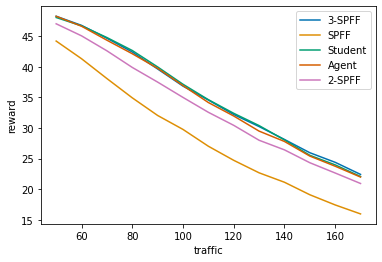

In [18]:
base_output_dir = './plots/rewards/'

output_dir = base_output_dir
os.makedirs(output_dir, exist_ok=True)
plt.figure()

for i, key in enumerate(rewards):
    plt.plot(traffics, rewards[key], label=key, color=colors[i])
plt.xlabel("traffic")
plt.ylabel("reward")
plt.legend()
plt.savefig(output_dir + f'{top_name}_{k_path}.png')
plt.show()

#### Features importance for the student trained with agent

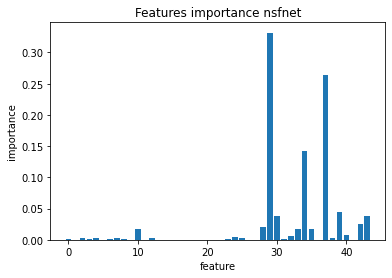

In [6]:
base_output_dir_features = './plots/features_importance/'

# loading saved DT classifier:
env, expert = get_EnvExpert(top_name, k_path, alg_name, mean_service_inter_arrival_time=0.1)
policy = DAgger_Policy.load(f'./tmp_students/nsfnet_{k_path}/model.h5',env.observation_space,env.action_space)

output_dir = base_output_dir_features
os.makedirs(output_dir, exist_ok=True)

importances_sk = policy.student.feature_importances_
importance = pd.DataFrame(importances_sk)
importance.to_csv(f'./plots/features_importance_{k_path}.csv')

plt.figure()
plt.bar([x for x in range(len(importances_sk))], importances_sk)
plt.xlabel("feature")
plt.ylabel("importance")
plt.title(f"Features importance {top_name}")
plt.savefig(output_dir + f'{top_name}_{k_path}.png')
plt.show()

#### Features importance for the student trained with heuristic

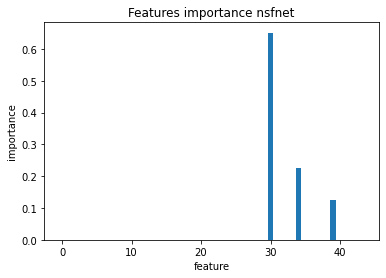

In [7]:
# loading saved DT classifier:
env, expert = get_EnvExpert(top_name, k_path, alg_name, mean_service_inter_arrival_time=0.1)
policy = DAgger_Policy.load(f'./tmp_students/nsfnet_heuristic_{k_path}/model.h5',env.observation_space,env.action_space)

output_dir = base_output_dir_features
os.makedirs(output_dir, exist_ok=True)

importances_sk = policy.student.feature_importances_
importance = pd.DataFrame(importances_sk)
importance.to_csv(f'./plots/features_importance_heuristic_{k_path}.csv')

plt.figure()
plt.bar([x for x in range(len(importances_sk))], importances_sk)
plt.xlabel("feature")
plt.ylabel("importance")
plt.title(f"Features importance {top_name}")
plt.savefig(output_dir + f'{top_name}_heuristic_{k_path}.png')
plt.show()

#### Decision tree structure

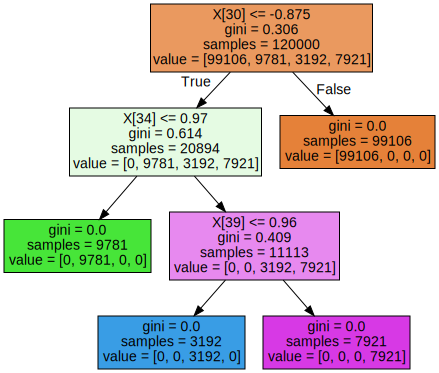

In [17]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(policy.student, out_file=None,
                                filled=True)
graphviz.Source(dot_data, format="png", directory='./',filename='tree.pdf') 